### Hyperbolic Diffusion Condensation for Multiscale Graph Representation
ICLR Computational Geometry & Topology Challenge 2022

**Authors:** Kisung You, Dhananjay Bhaskar, Smita Krishnaswamy

**Affiliation:** Yale University

### Abstract

Big data often has emergent structure that exists at multiple levels of abstraction, which are useful for characterizing complex interactions and dynamics of the observations. Here, we consider multiple levels of abstraction via a multiresolution geometry of data points at different granularities. To construct this geometry we define a time-inhomogeneous diffusion process that effectively condenses data points together to uncover nested groupings at larger and larger granularities. This inhomogeneous process creates a deep cascade of intrinsic low pass filters on the data affinity graph that are applied in sequence to gradually eliminate local variability while adjusting the learned data geometry to increasingly coarser resolutions. We provide visualizations to exhibit our method as a continuously-hierarchical clustering with directions of eliminated variation highlighted at each step. The utility of our algorithm is demonstrated here using both synthetic and 'real world' examples, where the constructed multiresolution data geometry uncovers the organization, grouping, and connectivity between entities that form a network. 

### 1. Introduction & Background

[Network](https://en.wikipedia.org/wiki/Network_theory) is a graph representation on how entities (**nodes**) are related to each other by connections (**edges**). The prevalence of network-valued data has seen numerous applications across many scientific domains including neuroscience, communications, sociology, and ecology. A common practice in network analysis is node representation learning, i.e. embedding nodes into a low-dimensional space for downstream analyses. While the primary choice of embedding space is the Euclidean space, other model spaces of constant curvature have recently attracted attention as they can better reflect the intrinsic geometry of a given network ([Smith et al, 2019](https://doi.org/10.1214/19-STS702)). For example, the hyperbolic space, which is a manifold of constant negative curvature, has been used to represent tree-like graphs with clandestine hierarchical structure.

In data science, it is often useful to view a given dataset across multiple scales or resolutions. This allows for examination of the differential characteristics of the data that may have not be apparent at a fixed resolution. The idea of multiscale analysis appeals broadly to many scientific communities. For instance, [scale-space](https://en.wikipedia.org/wiki/Scale_space) and [wavelet](https://en.wikipedia.org/wiki/Wavelet) theories have been influential frameworks for multiscale data representation in the discipline of signal processing. Given the objective of grouping data into sets of homogeneous observations, a class of [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) algorithms aims to achieve the goal by finding a series of data partitioning at multiple levels. Two of the most popular clustering algorithms are **K-Means Clustering** and **Mean Shift Clustering**. The following [jupyter notebook](https://github.com/geomstats/geomstats/blob/master/notebooks/05_riemannian_kmeans.ipynb) is a nice demonstration of Riemannian version of K-Means using Geomstats. But [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) algorithm has two important caveats:

1. One needs to specify $K$, the total number of clusters 
2. The algorithm is sensitive to initialization of the $K$ means

Mean-shift clustering mitigates both these issues. Mean shift clustering is a sliding-window based algorithm that attempts to find dense areas of data points. It is a centroid-based algorithm meaning that the goal is to locate the center points of each group/class, which works by updating candidates for center points to be the mean of the points within the sliding-window. These candidate windows are then filtered in a post-processing stage to eliminate near-duplicates, forming the final set of center points and their corresponding groups.

Our objective is to learn multiscale representation of a network by embedding it onto hyperbolic space (using `geomstats`). We perform network coarsensing by extending the [diffusion condensation](https://doi.org/10.1109/BigData47090.2019.9006013) algorithm (desribed below) to the hyperbolic setting. We use a Gaussian kernel for diffusion and the `geomstats` implementation of Frechet Mean for condensation. Using the iterative Hyperbolic Diffusion Condensation (HDC) procedure, we recover a dendrogram that represents the hierarchichal multi-resolution structure of the network. 

### 3. Methodology

The following pseudocode describes our implementation of hyperbolic diffusion condensation: 

![HDC](./imgs/HDC_alg.png)

where input data $X$ is embedded on the hyperboloid:

$$ \mathbb{H}^n = \Big\{ x \in \mathbb{R}^{n+1} : - x_1^2 + \sum_{i=2}^{n+1} x_i^2 = -1 \Big\} $$

with distance metric: $d(x,y) = \text{arccosh}\Big( -\sum_{i=1}^k x_iy_i + x_{k+1}y_{k+1}  \Big) $

**Diffusion Kernel:**

We use a Gaussian kernel to perform diffusion:

$$K^{(t)}(i,j) = \exp \Big( \frac{-d^2(X^{(t)}_i,X^{(t)}_j)}{\epsilon^{(t)}} \Big)$$

**Condensation:** 

We compute the Frechet mean using `geomstats.learning.frechet_mean`, which can be done in parallel:

$$X_i^* = \text{argmin}_X \sum_{j=1}^n P_{ij}^{(t)} d^2(X, X_j^{(t)})$$

**Convergence Criteria:** 

We use the diameter to fine-tune the kernel bandwidth to guarantee convergence:

$$\text{Diam}(X^{(t)}) = \max_{i,j} d(X_i^{(t)}, X_j^{(t)})$$

### 4. Installation

In [16]:
import sys

!{sys.executable} -m pip install networkx numpy scipy geomstats pandas matplotlib

You should consider upgrading via the '/Users/dbhaskar/VirtEnvs/RiemannianDC/bin/python3 -m pip install --upgrade pip' command.


### 5. Results

#### 5.1 Synthetic and 'toy' datasets

In [30]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np 

import matplotlib.pyplot as plt
from geomstats.geometry.hyperbolic import Hyperbolic
import geomstats.visualization as visualization

from HDC import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### 5.1.1 Karate Club

In [31]:
# setup : load data 
data_name = os.path.join(os.getcwd(),'data/karate3d.npy')
labs_name = os.path.join(os.getcwd(),"data/karatelab.npy")

data = np.load(data_name) # load the file
ndim = data.shape[1]-1    # intrinsic dimension
labs = np.load(labs_name, allow_pickle=True)

hyper_model = Hyperbolic(dim=ndim) # model space
if not np.all(hyper_model.belongs(data)):
    raise ValueError("* Some (or all) of the data points do not reside on Hyperboloid.")

In [32]:
# setup the parameters
par_epsilon = 0.01
par_tau     = 0.9   # contraction threshold parameter
par_scaler  = 1.2   # increasing
par_stop    = 1e-4

# run
rec_configs, rec_bandwidth, rec_diameter = runH2DC(data, epsilon=par_epsilon, tau=par_tau, scaler=par_scaler, stopping=par_stop)

Text(0.5, 0, 'iterations')

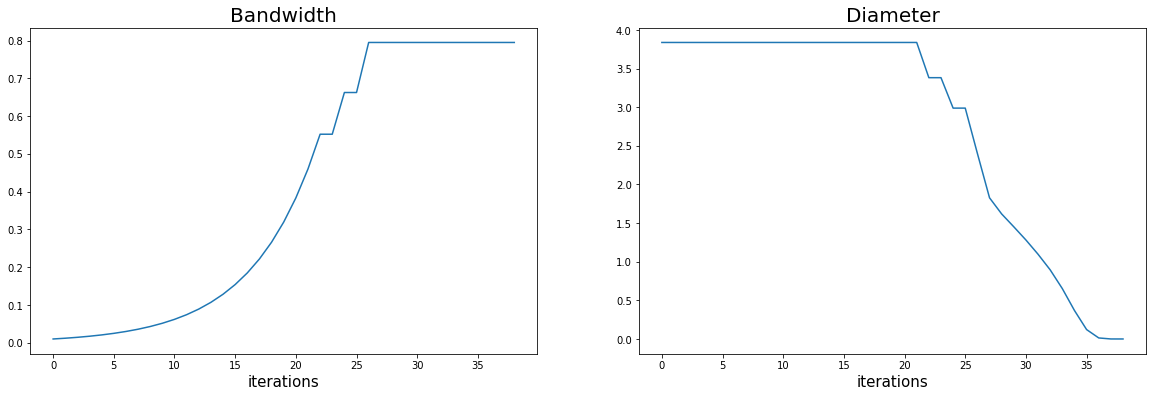

In [33]:
# visualize progression
fig, axes = plt.subplots(1,2, figsize=(20,6))

axes[0].plot(np.arange(len(rec_configs)), rec_bandwidth)
axes[0].set_title("Bandwidth", fontsize=20)
axes[0].set_xlabel("iterations", fontsize=15)

axes[1].plot(np.arange(len(rec_configs)), rec_diameter)
axes[1].set_title("Diameter", fontsize=20)
axes[1].set_xlabel("iterations", fontsize=15)

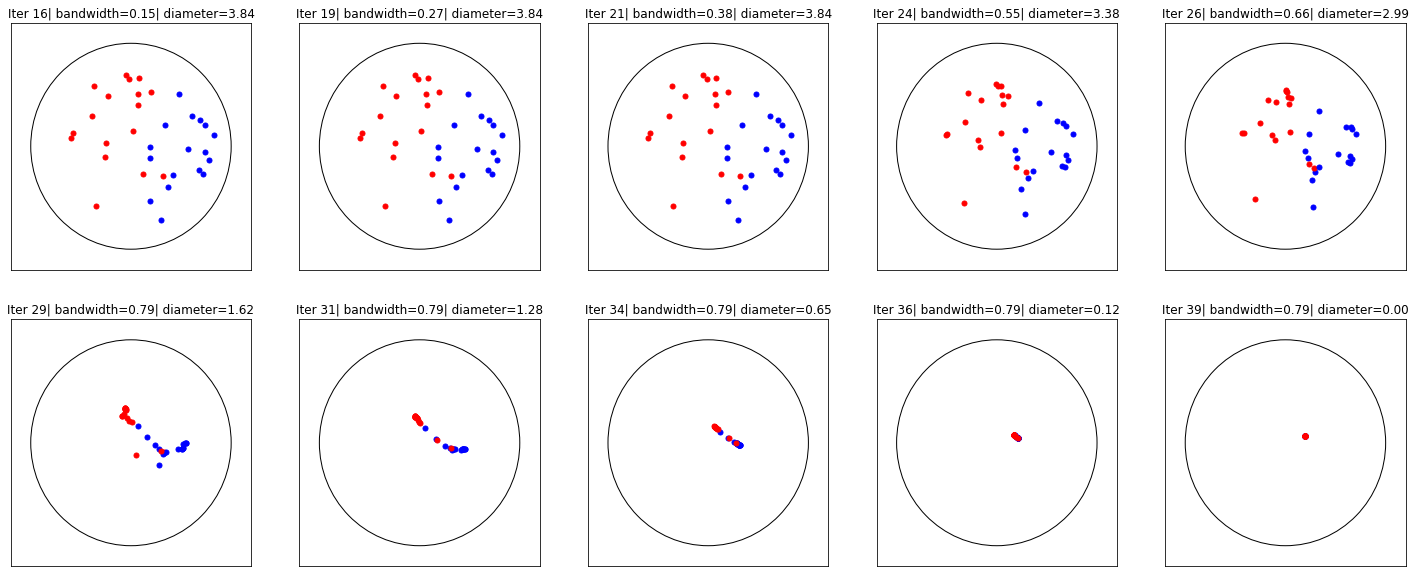

In [34]:
# visualize 10 intermittent values
show_nums = len(rec_configs)
show_ids  = np.linspace(15, show_nums-1, num=10)

circle = visualization.PoincareDisk(point_type="ball")
colors = {1: "b", 2: "r"}

fig, axes = plt.subplots(2,5,figsize=(25,10))
axes = axes.flatten()

for i in np.arange(10):
    # get the 2-dimensional embedding
    now_id = round(show_ids[i])
    vis2d = H2toDisk(rec_configs[now_id])

    # draw
    axes[i].axes.xaxis.set_visible(False)
    axes[i].axes.yaxis.set_visible(False)
    circle.set_ax(axes[i])
    circle.draw(ax=axes[i])

    for i_embedding, embedding in enumerate(vis2d):
        x = embedding[0]
        y = embedding[1]
        pt_id = i_embedding
        axes[i].scatter(x, y, c=colors[labs[i_embedding]], s=25)   # add a point
        # axes[i].annotate(pt_id, (x, y)) # add ID
    
    axes[i].set_title("Iter {}| bandwidth={:.2f}| diameter={:.2f}".format(now_id+1, rec_bandwidth[now_id], rec_diameter[now_id]))